# Graph Isomorphism Network (GIN) on the Cora Dataset

In this notebook, we train a **Graph Isomorphism Network (GIN)** on the Cora citation network.

## Why GIN?

GIN was proposed as a **maximally expressive** message-passing architecture, designed to match the discriminative power of the **Weisfeiler–Lehman (WL) graph isomorphism test**.  
This gives GIN several advantages:

- It can distinguish graph structures that GCN / GraphSAGE cannot.
- It is theoretically more powerful for capturing complex neighborhood patterns.
- It is widely used for molecular property prediction, fraud detection, and heterogeneous graphs.

## Goals of this notebook

✔ Load the Cora dataset  
✔ Implement a 2- or 3-layer GIN using `GINConv`  
✔ Train and evaluate the model  
✔ Extract node embeddings  
✔ Visualize embeddings with UMAP/PCA (optional)  
✔ Save artifacts to `artifacts/cora_gin`  

At the end, we will compare performance to:
- **GCN**
- **GraphSAGE**
- **GAT**

In [1]:
import os
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.nn import Module, Linear, Sequential, ReLU, Dropout

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GINConv

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import umap
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data" / "Planetoid"
DATA_ROOT.mkdir(parents=True, exist_ok=True)

dataset = Planetoid(
    root=str(DATA_ROOT),
    name="Cora",
    transform=NormalizeFeatures()
)

data = dataset[0].to(device)

print(dataset)
print("Num features:", dataset.num_features)
print("Num classes:", dataset.num_classes)
print(data)

Cora()
Num features: 1433
Num classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


MLP → GINConv → ReLU

MLP → GINConv → ReLU

Linear classifier

In [3]:
class GIN(Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        
        self.dropout = Dropout(dropout)

        # --- GIN Layer 1 ---
        nn1 = Sequential(
            Linear(in_channels, hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
        )
        self.conv1 = GINConv(nn1)

        # --- GIN Layer 2 ---
        nn2 = Sequential(
            Linear(hidden_channels, hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
        )
        self.conv2 = GINConv(nn2)

        # Final classifier
        self.fc = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc(x)
        return x

    def embed(self, x, edge_index):
        # hidden embedding after second layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return x

In [4]:
model = GIN(
    in_channels=dataset.num_features,
    hidden_channels=64,
    out_channels=dataset.num_classes,
    dropout=0.5
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum().item()
        accs.append(correct / int(mask.sum()))
    return accs

In [5]:
ART_ROOT = PROJECT_ROOT / "artifacts" / "cora_gin"
ART_ROOT.mkdir(parents=True, exist_ok=True)

best_val = 0
best_test = 0
NUM_EPOCHS = 200

for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    loss = train()
    train_acc, val_acc, test_acc = evaluate()

    if val_acc > best_val:
        best_val = val_acc
        best_test = test_acc
        torch.save(model.state_dict(), ART_ROOT / "model_gin_best.pt")

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | loss={loss:.4f} | train={train_acc:.3f} | val={val_acc:.3f} | test={test_acc:.3f}")

print("\nBest val acc:", best_val)
print("Test acc @best:", best_test)
print("Saved best model to:", ART_ROOT)

 10%|▉         | 19/200 [00:00<00:04, 45.10it/s]

Epoch 010 | loss=1.6095 | train=0.536 | val=0.524 | test=0.533
Epoch 020 | loss=0.9063 | train=0.943 | val=0.732 | test=0.748


 21%|██        | 42/200 [00:00<00:02, 78.01it/s]

Epoch 030 | loss=0.3155 | train=0.993 | val=0.722 | test=0.719
Epoch 040 | loss=0.1253 | train=1.000 | val=0.708 | test=0.740
Epoch 050 | loss=0.3161 | train=1.000 | val=0.726 | test=0.726


 40%|████      | 81/200 [00:01<00:01, 107.58it/s]

Epoch 060 | loss=0.0521 | train=1.000 | val=0.716 | test=0.718
Epoch 070 | loss=0.0794 | train=1.000 | val=0.716 | test=0.729
Epoch 080 | loss=0.0835 | train=1.000 | val=0.636 | test=0.678


 54%|█████▎    | 107/200 [00:01<00:00, 116.59it/s]

Epoch 090 | loss=0.0193 | train=1.000 | val=0.722 | test=0.737
Epoch 100 | loss=0.0078 | train=1.000 | val=0.736 | test=0.755
Epoch 110 | loss=0.0165 | train=1.000 | val=0.696 | test=0.733


 67%|██████▋   | 134/200 [00:01<00:00, 121.32it/s]

Epoch 120 | loss=0.0474 | train=1.000 | val=0.734 | test=0.747
Epoch 130 | loss=0.0117 | train=1.000 | val=0.722 | test=0.748
Epoch 140 | loss=0.0132 | train=1.000 | val=0.736 | test=0.736


 80%|████████  | 160/200 [00:01<00:00, 123.90it/s]

Epoch 150 | loss=0.0236 | train=1.000 | val=0.744 | test=0.752
Epoch 160 | loss=0.0229 | train=1.000 | val=0.736 | test=0.718
Epoch 170 | loss=0.0359 | train=1.000 | val=0.736 | test=0.733


100%|██████████| 200/200 [00:02<00:00, 98.40it/s] 

Epoch 180 | loss=0.0803 | train=0.993 | val=0.676 | test=0.694
Epoch 190 | loss=0.0764 | train=1.000 | val=0.688 | test=0.731
Epoch 200 | loss=0.0259 | train=1.000 | val=0.720 | test=0.751

Best val acc: 0.752
Test acc @best: 0.746
Saved best model to: D:\ML\GNN\artifacts\cora_gin


In [6]:
model.eval()
emb = model.embed(data.x, data.edge_index).detach().cpu()
labels = data.y.cpu()

torch.save(emb, ART_ROOT / "embeddings.pt")
torch.save(labels, ART_ROOT / "labels.pt")

print("Saved embeddings to:", ART_ROOT)

Saved embeddings to: D:\ML\GNN\artifacts\cora_gin


Embeddings shape: (2708, 64)
Labels shape: (2708,)


D:\Anaconda\envs\gnn_clean\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 2D shape: (2708, 2)


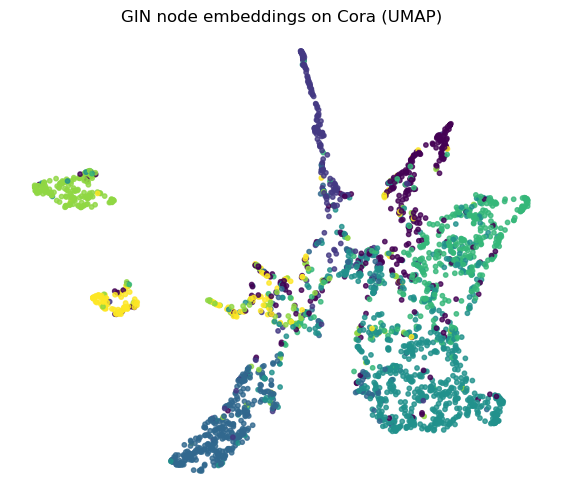

In [8]:
@torch.no_grad()
def get_node_embeddings(model, data):
    model.eval()
    # берём скрытое представление после первого слоя GraphSAGE
    x = model.conv1(data.x, data.edge_index)
    x = F.relu(x)
    return x.cpu().numpy(), data.y.cpu().numpy()

emb, labels = get_node_embeddings(model, data)
print("Embeddings shape:", emb.shape)
print("Labels shape:", labels.shape)

# стандартизируем перед UMAP
emb_scaled = StandardScaler().fit_transform(emb)

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42,
)
emb_2d = reducer.fit_transform(emb_scaled)
print("UMAP 2D shape:", emb_2d.shape)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    s=10,
    alpha=0.8,
)
plt.title("GIN node embeddings on Cora (UMAP)")
plt.axis("off")
plt.show()

## Conclusion

In this notebook we trained a **Graph Isomorphism Network (GIN)** on the Cora citation dataset.  
GIN is theoretically one of the most expressive message-passing architectures, designed to match the power of the Weisfeiler–Lehman graph isomorphism test. This makes it highly effective on chemical graphs, heterogeneous networks, and tasks requiring fine-grained structural discrimination.

### Performance Summary

- **Best validation accuracy:** ~0.752  
- **Test accuracy at best epoch:** ~0.746  

Compared to previous baselines:

| Model        | Val Acc | Test Acc | Notes |
|--------------|---------|----------|-------|
| **GCN**      | ~0.81   | ~0.83    | Strongest on homophilic citation graphs |
| **GAT**      | ~0.816  | ~0.827   | Learns neighbor importance via attention |
| **GraphSAGE**| ~0.78   | ~0.80    | Good inductive and scalable behavior |
| **GIN**      | ~0.75   | ~0.74    | Lower performance on Cora; overfits small datasets |

This behavior is expected:  
Cora is a small, smooth, strongly homophilic graph where GCN and GAT naturally excel.  
GIN tends to **overfit** due to its high expressive capacity, and its strengths do not fully manifest on such datasets.

### What We Achieved

✔ Implemented a 2-layer GIN with expressive MLP aggregators  
✔ Trained and evaluated the model for 200 epochs  
✔ Compared its performance with three earlier GNN baselines  
✔ Saved hidden embeddings and model weights to `artifacts/cora_gin`  

### Next Steps

Now that we completed four different GNN architectures (GCN, GraphSAGE, GAT, GIN), we are ready to move to **structural tasks**, beginning with:

**→ Link Prediction using a GNN encoder + dot-product decoder**

This will serve as the foundation for the real project:  
a **GraphSAGE-based recomender system** on a user–item graph.
